<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/text/spanish_english_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Level Seq2Seq Model

Shamelessly, copied from [here](https://github.com/hlamba28/Word-Level-Eng-Mar-NMT/blob/master/WordLevelEngMarNMT.ipynb)

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [8]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2020-04-17 17:43:18--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  12.2MB/s    in 0.4s    

2020-04-17 17:43:19 (12.2 MB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [9]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1441  2020-03-15 02:17   _about.txt
 18493172  2020-03-15 02:17   spa.txt
---------                     -------
 18494613                     2 files
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [0]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Disabling eager execution because all zeros mask raises some CuDNN kernel level issue. Refere [here](https://github.com/tensorflow/tensorflow/issues/33148)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])
# lines = pd.DataFrame({"english": ["Juan eats apples"], "spanish": ["Juan come manzanas"], "attributes": ""})

In [78]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences
lines['spanish'] = lines['spanish'].apply(lambda x : 'START_ '+ x + ' _END')

In [0]:
pd.set_option('display.max_colwidth', 100)

In [83]:
lines.head(10)

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END
5,run,START_ ¡corre _END
6,run,START_ ¡corran _END
7,run,START_ ¡corra _END
8,run,START_ ¡corred _END
9,run,START_ corred _END


## Creating Vocabulary
Create vocabulary of english and spanish words

In [84]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13475


In [85]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [86]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 47


In [87]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 47


In [88]:
matches = [i for i, j in zip(lenght_list_eng, lenght_list_spa) if i == j]
print(f"Number of matches: {len(matches)} ({(len(matches)*100/lines.shape[0]):.2f})")

Number of matches: 13865 (11.20)


In [89]:
lines.head()

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END


In [90]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13475, 27264)

In [0]:
num_encoder_tokens += 1 # For zero padding
num_decoder_tokens += 1 # For zero padding

## Embedding

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [94]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

a 1
aardvark 2
aardvarks 3
aaron 4
aback 5
abandon 6
abandoned 7
abandoning 8
abate 9
abated 10


In [95]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

START_ 1
_END 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [97]:
lines = shuffle(lines)
lines.head(10)

,english,spanish
14135,i miss my friends,START_ echo de menos a mis amigos _END
108258,id like to ask tom to answer a few questions,START_ me gustaría pedirle a tomás que respondiera algunas preguntas _END
18197,our team could win,START_ nuestro equipo puede ganar _END
50818,i like this house as it is,START_ me gusta esta casa así como es _END
80228,let me have a look at the picture,START_ déjame echarle un vistazo a la imagen _END
65879,tom was suspended from school,START_ tom fue suspendido de la escuela _END
57456,tom wanted you to have this,START_ tom quería que tengas esto _END
119424,they sounded the alarm when they saw the enemy approaching,START_ sonaron la alarma cuando vieron al enemigo acercándose _END
115841,i will try to pay what i owe by the end of the month,START_ trataré de pagar lo que debo de aquí a final de mes _END
96603,i am very grateful to you for your help,START_ te estoy muy agradecido por la ayuda _END


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
X_train.shape, y_train.shape

((99016,), (99016,))

In [101]:
X_test.shape, y_test.shape

((24754,), (24754,))

## Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Teacher Forcing
Teacher forcing works by using the actual or expected output from the training dataset at the current time step `y(t)` as input in the next time step `X(t+1)`, rather than the output generated by the network.

Decoder is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Effectively, the decoder learns to generate targets `[t+1...]` given targets `[...t]`, conditioned on the input sequence.


### Example - 
Suppose, we had only 1 sentence -
* `English` - Juan eats apples
* `Spanish` - Juan come manzanas

Hence, we had just 3 words in our English & 5 in Spanish vocabulary. 
```
English Vocabulary
{'apples': 1, 'eats': 2, 'juan': 3}

Spanish Vocabulary
{'START_': 1, '_END': 2, 'come': 3, 'juan': 4, 'manzanas': 5}
```

So our encoded input & decoder input would look like - 
```
Encoder Input Data: [[3. 2. 1.]]

Decoder Input Data: [[1. 4. 3. 5. 0.]]
```

As the target sentence has 5 words, at timestep `t` during training, we set the previous timestep's `t-1` actual output to 1. So essentially, we will have 5 target sentence.

```
Decoder Target Data: 
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # come
[0. 0. 0. 0. 0. 1.] # manzanas
[0. 0. 1. 0. 0. 0.] # _END
[0. 0. 0. 0. 0. 0.]
```

### Summary
TS1 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 1. 0.] # juan
```

TS2 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 1. 0. 0.] # juan come
```

TS3 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 0. 1.] # juan come manzanas
```

TS4 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 1. 0. 0. 0. 0.] # juan come manzanas _END
```


In [0]:
# batch_size = 1

# for j in range(0, len(X), batch_size):
#     encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
#     decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
#     decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
#     for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
#         for t, word in enumerate(input_text.split()):
#             print(f"Input: {word}")
#             encoder_input_data[i, t] = input_token_index[word] # encoder input seq
#         for t, word in enumerate(target_text.split()):
#             print(f"Target: {word}")
#             if t<len(target_text.split())-1:
#                 decoder_input_data[i, t] = target_token_index[word] # decoder input seq
#             if t>0:
#                 # decoder target sequence (one hot encoded)
#                 # does not include the START_ token
#                 # Offset by one timestep
#                 decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#     print(f"Encoder Input Data: {encoder_input_data}") 
#     print(f"Decoder Input Data: {decoder_input_data}")
#     print(f"Decoder Target Data:\n {decoder_target_data}")
#     # print(f"Decoder Target Data:\n {decoder_target_data[:, :-1, :]}")

## Model

In [0]:
latent_dim = 50

In [105]:
# ENCODER
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [107]:
# set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Model will take encoder inputs & decoder inputs and return decoder outputs

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

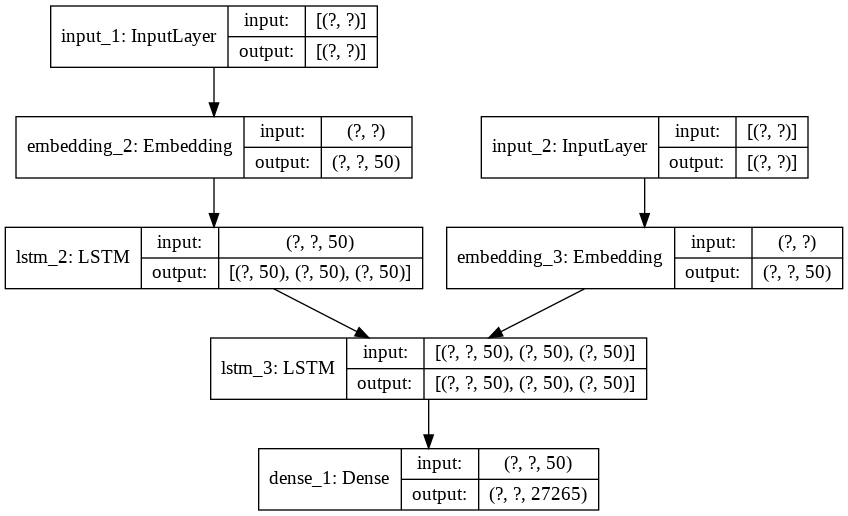

In [109]:
plot_model(model, show_shapes=True)

## Training

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [0]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size
                    )

In [0]:
model.save_weights("english_to_spanish_nmt.h5")

## Inference

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
dec_emb2 = dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Training Data

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [125]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Translation:', decoded_sentence[:-4])
    print("="*30, end="\n\n")

Input Sentence: its not cheap
Actual Translation:  no es barato 
Predicted Translation:  no no 

Input Sentence: i dont know many french songs
Actual Translation:  no conozco muchas canciones francesas 
Predicted Translation:  no no francés francés francés 

Input Sentence: many people think that antique cars are overpriced
Actual Translation:  mucha gente piensa que los autos antiguos están sobrevaluados 
Predicted Translation:  el el el el el el el 

Input Sentence: everyone else is drinking beer
Actual Translation:  todos los demás están tomando cerveza 
Predicted Translation:  en más de de 

Input Sentence: it is illegal to park a car there
Actual Translation:  es ilegal parar el carro ahí 
Predicted Translation:  es un un en en la la 

Input Sentence: ill get in touch with tom by telephone tomorrow and ask him to give us a hand
Actual Translation:  me pondré en contacto con tom por teléfono mañana y le pediré que nos dé una mano 
Predicted Translation:  a con con con con con a a a

### Testing Data

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [127]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Translation:', decoded_sentence[:-4])
    print("="*30, end="\n\n")

Input Sentence: tom is just like me
Actual Translation:  tom es igual que yo 
Predicted Translation:  no no no 

Input Sentence: wheres the restroom
Actual Translation:  ¿dónde está el baño 
Predicted Translation:  el el el 

Input Sentence: youre a bit taller than i am arent you
Actual Translation:  vosotras sois un poco más altas que yo ¿no 
Predicted Translation:  más más más más que 

Input Sentence: the people have made their preparations for the trip
Actual Translation:  la gente hizo sus preparativos para el viaje 
Predicted Translation:  el el el el el el la la la la la 

Input Sentence: tom had a fight with mary
Actual Translation:  tom tuvo una pelea con mary 
Predicted Translation:  tom a a a a 

Input Sentence: were not doing this for the money
Actual Translation:  no estamos haciendo esto por dinero 
Predicted Translation:  no no a a 

Input Sentence: tom cant find his keys
Actual Translation:  tom no encuentra sus llaves 
Predicted Translation:  no no tom tom tom 

Input 